In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device3 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [3]:
import pickle

with open('./turing_Brusselator_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:
#with open('./turing_Brusselator_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
    sol = np.load(f)
    
with open('./turing_Brusselator_params_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_params_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:    
#with open('./turing_Brusselator_params_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
    params = pickle.load(f)

In [4]:
sol.shape, params

((3, 2, 1024),
 {'D_U': 0.0016,
  'D_V': 0.0135,
  'A': 4.0,
  'B': 11.0,
  'n': 32,
  'delta_t': 0.01,
  'Lx': 0.5,
  'Ly': 0.5,
  'T': 10000})

In [5]:
torch.manual_seed(42)
np.random.seed(42)

#D_U = params["D_U"]#0.0016
#D_V = params["D_V"]#0.0131

x = torch.linspace(0, params["Lx"], 32, device=dev_str)
y = torch.linspace(0, params["Ly"], 32, device=dev_str)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
data_X = data_X.detach().clone()
data_X.requires_grad = True

# data_x = torch.linspace(0, params["Lx"], 128).to(device)
# data_y = torch.linspace(0, params["Ly"], 128).to(device)
# X,Y = torch.meshgrid(x, y, indexing='ij')
# physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)


data_U = torch.from_numpy(sol[-1, 0, :])
data_V = torch.from_numpy(sol[-1, 1, :])
data_f = torch.vstack([data_U, data_V]).T.to(device)

N = params["n"]**2
domain_bounds = torch.tensor([params["Lx"], params["Ly"]]).to(device)


A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_As = []
B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_Bs = []
D_U = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_D_Us = []
D_V = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
sampled_D_Vs = []




lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([params["Lx"], params["Ly"]]).to(device)
model = Net_dense_normalised([2, 128, 128, 128, 128, 2], lb, ub).to(device)

# optimizer = torch.optim.Adam([
#                              {'params': model.parameters()},
#                              {'params': [A, B], 'lr': 0.01}],
#                              lr=1e-4, weight_decay=0.0001)
optimizer = torch.optim.Adam([
                             {'params': model.parameters()},
                             {'params': [D_U, D_V, A, B], 'lr': 0.01}],
                             lr=1e-4, weight_decay=0.0001)
epochs = 400000
loss_data = 0.0
lambda_data = 1.0#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#1.0
loss_physics = 0.0
lambda_physics = 1e-1#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#5e-2


losses = np.zeros((2, epochs))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # randomly select 1/4th of them
    random_indices = torch.randperm(data_X.shape[0])[:N]
    data_f_hat = model(data_X[random_indices,:]).squeeze()
    loss_data = torch.mean((data_f[random_indices,:] - data_f_hat)**2)


    #################################
    # physics derivatives
    # random points from U(0,1)
    # When multiplied with Lx and Ly
    physics_X = torch.rand((N,2), requires_grad=True ,device=dev_str)*domain_bounds    
    physics_f = model(physics_X).squeeze()
    U = physics_f[:,0]
    V = physics_f[:,1]
    dxy  = torch.autograd.grad(U, physics_X, torch.ones_like(U), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianU = dx2 + dy2
    
    dxy  = torch.autograd.grad(V, physics_X, torch.ones_like(V), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianV = dx2 + dy2

        
    FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
    FU2 = torch.exp(A)/torch.exp(D_U) - (torch.exp(B) + 1) * U/torch.exp(D_U) + U*U*V/torch.exp(D_U)
    FV = torch.exp(B) * U - U*U*V
    FV2 = torch.exp(B) * U/torch.exp(D_U) - U*U*V/torch.exp(D_U)
    
    dudt = torch.exp(D_U) * laplacianU + FU
    dudt2 = laplacianU + FU2
    dvdt = torch.exp(D_V) * laplacianV + FV
    dvdt2 = laplacianV + FV2
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(dudt**2 + dudt2**2 + dvdt**2 + dvdt2**2)    
    
    total_loss = (
        +lambda_data*loss_data
        +lambda_physics*loss_physics        
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), loss_physics.item())
    sampled_D_Us.append(D_U.item())
    sampled_D_Vs.append(D_V.item())
    sampled_As.append(A.item())
    sampled_Bs.append(B.item())

#     a, b = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
#     a2,b2 = 64*10*a, b
#     lambda_physics = a2/(a2+b2)
#     lambda_data = 1.0 - lambda_physics
#     grad_data, grad_phy = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
#     loss_data, loss_phy = losses[0,i], losses[1,i]
#     w1 = loss_data**2/np.sqrt(grad_data)
#     w2 = loss_phy**2/np.sqrt(grad_phy)
#     lambda_physics = w2/(w1+w2)
#     lambda_data = 1.0 - lambda_physics
    
    
    
    if i%5000 == 0:
        print(f"Epoch: {i}")
        print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
        print(f"D_U: {np.exp(sampled_D_Us[-1]):.4f}, D_V: {np.exp(sampled_D_Vs)[-1]:.4f}")
        print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")
#         print(f"grad_data: {grad_data:.10f}, grad_physics: {grad_phy:.10f}")
#         print(f"lambda_data: {lambda_data:.6f}, lambda_physics: {lambda_physics:.6f}")
        


Epoch: 0
loss data: 17.344028, loss physics: 5.384884
D_U: 2.7456, D_V: 2.6912
A: 2.6912, B: 2.7456
Epoch: 5000
loss data: 6.644945, loss physics: 0.003444
D_U: 1.3861, D_V: 1.3801
A: 8.8402, B: 9.6954
Epoch: 10000
loss data: 6.640927, loss physics: 0.009460
D_U: 1.3493, D_V: 1.3536
A: 6.6635, B: 9.7770
Epoch: 15000
loss data: 6.630819, loss physics: 0.015793
D_U: 0.9692, D_V: 0.9699
A: 3.7206, B: 10.1069
Epoch: 20000
loss data: 6.622533, loss physics: 0.011536
D_U: 0.8565, D_V: 0.8565
A: 1.9957, B: 10.4861
Epoch: 25000
loss data: 6.619207, loss physics: 0.011341
D_U: 0.8115, D_V: 0.8120
A: 1.0972, B: 10.6995
Epoch: 30000
loss data: 6.617326, loss physics: 0.014297
D_U: 0.7938, D_V: 0.7938
A: 0.6898, B: 10.8374
Epoch: 35000
loss data: 6.615793, loss physics: 0.039593
D_U: 0.7873, D_V: 0.7873
A: 0.5029, B: 10.9352
Epoch: 40000
loss data: 6.614322, loss physics: 0.030676
D_U: 0.7764, D_V: 0.7763
A: 0.4132, B: 11.0295
Epoch: 45000
loss data: 6.612899, loss physics: 0.007042
D_U: 0.7594, D

Epoch: 395000
loss data: 6.368617, loss physics: 0.167829
D_U: 0.2754, D_V: 0.2760
A: 0.2240, B: 10.8520


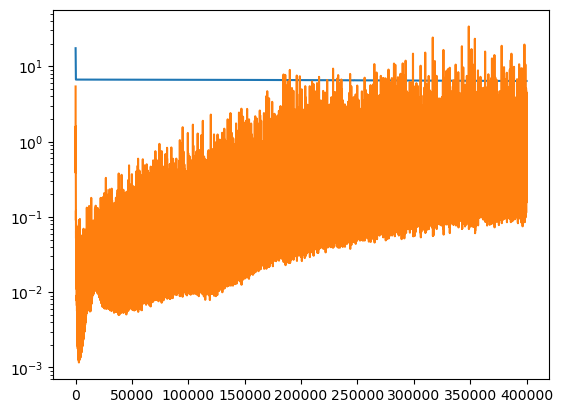

0.22454703001226545 10.825356978899428 396513


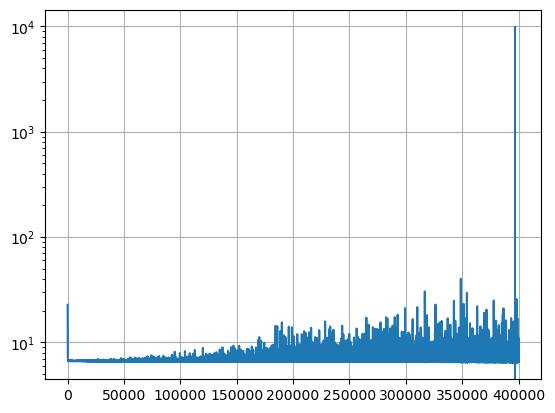

In [6]:
plt.plot(losses[0,:])
plt.plot(losses[1,:])
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
plt.yscale('log'); plt.vlines(index, 0, 10000);plt.grid();

plt.show()

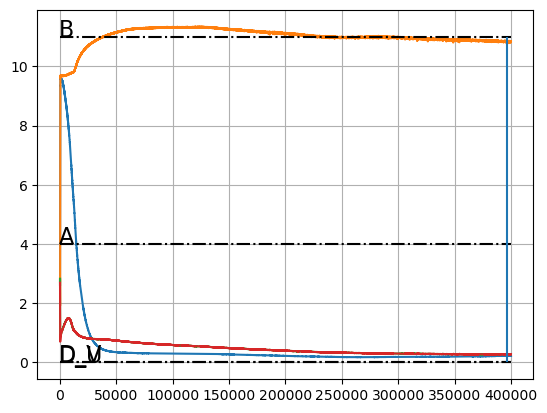

0.22744154436677663 10.849479716765176
0.23495732980390238 0.04943622452501776 11.081345033711182 0.16276719209351875
0.41111685490797467 0.1335953698585008 0.41113619144181546 0.1336190101029652


In [8]:
plt.plot(np.exp(sampled_As))
plt.plot(np.exp(sampled_Bs))
plt.plot(np.exp(sampled_D_Us))
plt.plot(np.exp(sampled_D_Vs))
plt.hlines(params["A"], 0, epochs, linestyles="-.", color="black")
plt.annotate("A", (-1000, params["A"]), (-1000, params["A"]), fontsize=16)
plt.hlines(params["B"], 0, epochs, linestyles="-.", color="black")
plt.annotate("B", (-1000, params["B"]), (-1000, params["B"]), fontsize=16)
plt.hlines(params["D_U"], 0, epochs, linestyles="-.", color="black")
plt.annotate("D_U", (-1000, params["D_U"]), (-1000, params["D_U"]), fontsize=16)
plt.hlines(params["D_V"], 0, epochs, linestyles="-.", color="black")
plt.annotate("D_V", (-1000, params["D_V"]), (-1000, params["D_V"]), fontsize=16)
plt.vlines(index, 0, 11);plt.grid();#plt.ylim(0, 2)
plt.show()
print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))
print(np.mean(np.exp(sampled_As[50000:])),np.std(np.exp(sampled_As[50000:])),
      np.mean(np.exp(sampled_Bs[50000:])), np.std(np.exp(sampled_Bs[50000:])))

print(np.mean(np.exp(sampled_D_Us[50000:])),np.std(np.exp(sampled_D_Us[50000:])),
      np.mean(np.exp(sampled_D_Vs[50000:])), np.std(np.exp(sampled_D_Vs[50000:])))

In [9]:
np.mean(np.exp(sampled_D_Vs[60000:]))/np.mean(np.exp(sampled_D_Us[60000:])), params["D_V"]/params["D_U"]

(1.0000436816275933, 8.4375)

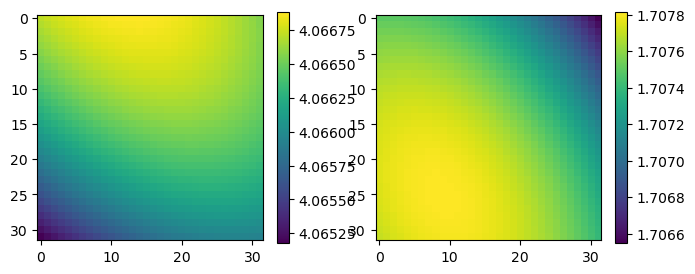

In [155]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((32, 32))
V_hat = solution[:, 1].reshape((32, 32))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.7947e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


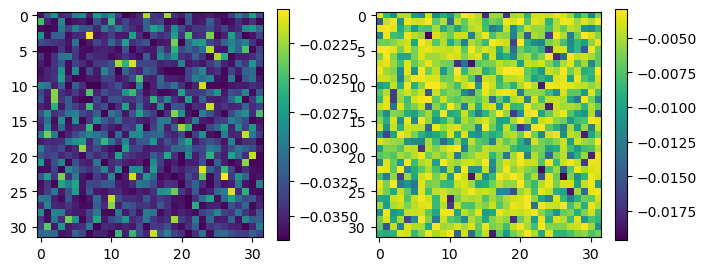

In [160]:
print(torch.mean((params["D_U"]*laplacianU - FU)**2),
      torch.mean((params["D_V"]*laplacianV- FV)**2))

estimated_D_U = np.mean(np.exp(sampled_D_Us[50000:]))
estimated_D_V = np.mean(np.exp(sampled_D_Vs[50000:]))
print(torch.mean((estimated_D_U*laplacianU - FU)**2),
      torch.mean((estimated_D_V*laplacianV- FV)**2))
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.array((params["D_U"]*laplacianU - FU).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(np.array((params["D_V"]*laplacianV- FV).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.show()

In [157]:
FU2 = torch.exp(A) - (11 + 1) * U + U*U*V
FV2 = 11 * U - U*U*V

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.7947e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(270.8160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(272.1475, device='cuda:0', grad_fn=<MeanBackward0>)


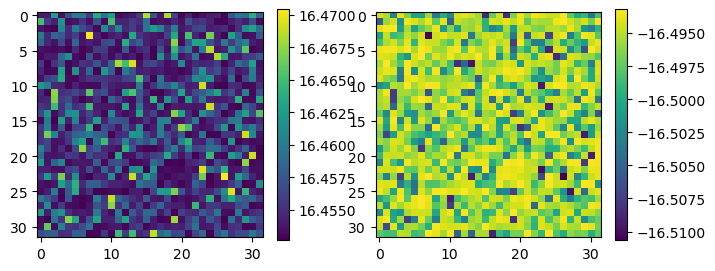

In [158]:
print(torch.mean((params["D_U"]*laplacianU - FU)**2),
      torch.mean((params["D_V"]*laplacianV- FV)**2))
print(torch.mean((params["D_U"]*laplacianU - FU2)**2),
      torch.mean((params["D_V"]*laplacianV- FV2)**2))

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.array((params["D_U"]*laplacianU - FU2).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(np.array((params["D_V"]*laplacianV- FV2).cpu().detach()).reshape((32,32)))
plt.colorbar(shrink=.75)
plt.show()